### Regression Problem : Predicting the house price

In [1]:
from myutils import *

In [2]:
#import
from keras import layers, models, optimizers, losses, metrics
from keras.datasets import boston_housing
from keras.utils.np_utils import to_categorical
import numpy as np

Using Theano backend.


In [3]:
(train_data, train_price),(test_data, test_price) = boston_housing.load_data()

In [4]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [5]:
print(train_price.shape)
print(test_price.shape)

(404,)
(102,)


**Standarization the data points**  
standardization transforms data to have a mean of zero and a standard deviation of 1. This standardization is called a z-score

In [6]:
mean = np.mean(train_data,axis=0)
train_data = train_data-mean
std = np.std(train_data,axis=0)
train_data = train_data / std


test_data = (test_data - mean)/std

### Building the network

In [7]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))      # Network with Single Layer and NO Activation means - It is linear and can predict any continuous value
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

    Network with Single Layer and NO Activation means - It is linear and can predict any continuous value  
    Applying the activation function can constraints the output values, if we use Sigmoid, it will be between 0 and 1  
    mse - mean squared error  
    mae - mean absolute error   
    
    As we have very limited data, we will not go for training and validation data split which can cause very less no  
    for validation data but use the K-Fold CV technique to provide the enough data for training and validation

In [8]:
num_epochs = 100
k = 4
num_val_samples = len(train_data)//k
num_val_samples

101

In [9]:
scores = []

for i in range(k):
    x_val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    y_val_data = train_price[i*num_val_samples:(i+1)*num_val_samples]
    
    x_partial_data = np.concatenate([train_data[(i+1)*num_val_samples:], 
                                     train_data[:i*num_val_samples]], 
                                    axis=0)
    
    y_partial_data = np.concatenate([train_price[(i+1)*num_val_samples:], 
                                     train_price[:i*num_val_samples]], 
                                    axis=0)
    
    print("CV: ",i+1)
    print("Training Set Size: ",len(x_partial_data), len(y_partial_data))
    print("Validation Set Size: ",len(x_val_data), len(y_val_data))
    
    print("Processing.....")
    model = build_model()
    history = model.fit(x_partial_data, 
              y_partial_data,
             epochs = num_epochs,
             batch_size=1,
             verbose=0)
    val_mse, val_mae = model.evaluate(x_val_data, y_val_data, verbose=0)
    
    scores.append(val_mae)
    print("Processing Completed.")

print("\n")
print("Scores: ", scores)
print("Mean Scores: ", np.mean(scores))

CV:  1
Training Set Size:  303 303
Validation Set Size:  101 101
Processing.....


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Processing Completed.
CV:  2
Training Set Size:  303 303
Validation Set Size:  101 101
Processing.....
Processing Completed.
CV:  3
Training Set Size:  303 303
Validation Set Size:  101 101
Processing.....
Processing Completed.
CV:  4
Training Set Size:  303 303
Validation Set Size:  101 101
Processing.....
Processing Completed.


Scores:  [1.9100549858395417, 2.4096976483222283, 2.6506179866224233, 2.6126940923162025]
Mean Scores:  2.39576617828


    verbose =0, Building the model in silent mode

In [10]:
num_epochs = 500
all_mae_hist = []
for i in range(k):
    x_val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    y_val_data = train_price[i*num_val_samples:(i+1)*num_val_samples]
    
    x_partial_data = np.concatenate([train_data[(i+1)*num_val_samples:], 
                                     train_data[:i*num_val_samples]], 
                                    axis=0)
    
    y_partial_data = np.concatenate([train_price[(i+1)*num_val_samples:], 
                                     train_price[:i*num_val_samples]], 
                                    axis=0)
    
    print("CV Processing.....: ",i+1)
    #print("Training Set Size: ",len(x_partial_data), len(y_partial_data))
    #print("Validation Set Size: ",len(x_val_data), len(y_val_data))
    
    #print("Processing.....")
    model = build_model()
    history = model.fit(x_partial_data, 
              y_partial_data,
              validation_data = (x_val_data, y_val_data),
             epochs = num_epochs,
             batch_size=1,
             verbose=0)
    # val_mse, val_mae = model.evaluate(x_val_data, y_val_data, verbose=0)
    
    all_mae_hist.append(history.history['val_mean_absolute_error'])
    print("Processing Completed.")

CV Processing.....:  1
Processing Completed.
CV Processing.....:  2
Processing Completed.
CV Processing.....:  3
Processing Completed.
CV Processing.....:  4
Processing Completed.


In [11]:
avg_mean_hist = [np.mean([x[i] for x in all_mae_hist]) for i in range(num_epochs)]

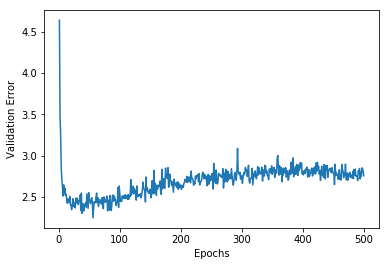

In [12]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, num_epochs+1), avg_mean_hist)
plt.xlabel('Epochs')
plt.ylabel('Validation Error')
plt.show()

#### Plotting validation scores, excluding the first 10 data points

In [15]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [18]:
smooth_mae_history = smooth_curve(avg_mean_hist[10:])

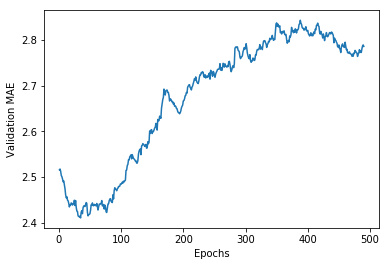

In [19]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

As we can see in above graph, MAE stopped improving after epochs 80

In [21]:
scores = []
num_epochs = 80
for i in range(k):
    x_val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    y_val_data = train_price[i*num_val_samples:(i+1)*num_val_samples]
    
    x_partial_data = np.concatenate([train_data[(i+1)*num_val_samples:], 
                                     train_data[:i*num_val_samples]], 
                                    axis=0)
    
    y_partial_data = np.concatenate([train_price[(i+1)*num_val_samples:], 
                                     train_price[:i*num_val_samples]], 
                                    axis=0)
    
    print("CV: ",i+1)
    print("Training Set Size: ",len(x_partial_data), len(y_partial_data))
    print("Validation Set Size: ",len(x_val_data), len(y_val_data))
    
    print("Processing.....")
    model = build_model()
    history = model.fit(x_partial_data, 
              y_partial_data,
             epochs = num_epochs,
             batch_size=1,
             verbose=0)
    val_mse, val_mae = model.evaluate(x_val_data, y_val_data, verbose=0)
    
    scores.append(val_mae)
    print("Processing Completed.")

print("\n")
print("Scores: ", scores)
print("Mean Scores: ", np.mean(scores))

CV:  1
Training Set Size:  303 303
Validation Set Size:  101 101
Processing.....
Processing Completed.
CV:  2
Training Set Size:  303 303
Validation Set Size:  101 101
Processing.....
Processing Completed.
CV:  3
Training Set Size:  303 303
Validation Set Size:  101 101
Processing.....
Processing Completed.
CV:  4
Training Set Size:  303 303
Validation Set Size:  101 101
Processing.....
Processing Completed.


Scores:  [2.097248929561955, 2.4118800186874845, 2.6862706996426722, 2.3774983711762006]
Mean Scores:  2.39322450477
